In [1]:
%pip install -q matplotlib
%pip install -q torchviz torchinfo
%pip install -q tqdm

In [2]:
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

import torch
from torch import nn, optim
from torchinfo import summary

%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (3, 3)
plt.rcParams['axes.grid'] = True
np.set_printoptions(suppress=True, precision=4)

## MNIST

#### GPU Acceleration

In [3]:
# Enable GPU device if available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
x = torch.randn(2, 2)
model = torch.nn.Linear(1, 1)
w1, b1 = list(model.parameters())[:2]
print(f'x: {x.device}, Layer1: {w1.device}, {b1.device}')

x = x.to(device)
model = model.to(device)
print(f'x: {x.device}, Layer1: {w1.device}, {b1.device}')

x: cpu, Layer1: cpu, cpu
x: cuda:0, Layer1: cuda:0, cuda:0


#### Pre-processing by transforms

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


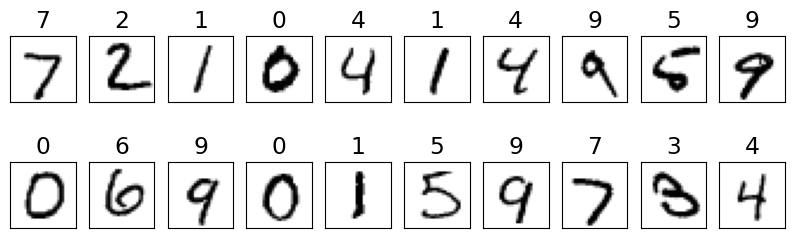

In [6]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),                   # numpy -> torch.Tensor
    transforms.Normalize(0.5,  0.5),         # Normalize
    transforms.Lambda(lambda x: x.view(-1))  # Tensor(28, 28) -> Tensor(784)
])

def decode_to_image(x):
    x = x.view(28, 28)
    x = x * 0.5 + 0.5
    return transforms.ToPILImage()(x)

# Download datasets and transform them.
data_root = '/content/drive/MyDrive/datasets'

train_dataset = datasets.MNIST(
    root=data_root,  train=True, download=True,
    transform = transform)

test_dataset = datasets.MNIST(
    root=data_root,  train=False, download=True,
    transform = transform)

# Visualize images.
plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)
    input, label = test_dataset[i]
    image = decode_to_image(input)

    plt.imshow(image, cmap='gray_r')
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Mini-Batch Training
| Batch Size | Time | Accuracy | Remarks |
| --- | --- | --- | --- |
| Large | Short | Low  | Stable learning due to noise robustness<br>Risk of local minimum.|
| Small | Long  | High | Learning stagnation due to noise sensitivity |

In [7]:
from torch.utils.data import DataLoader

batch_size = 500
train_loader = DataLoader(
    train_dataset, batch_size = batch_size,
    shuffle = True)

test_loader = DataLoader(
    test_dataset,  batch_size = batch_size,
    shuffle = False)

print(f'train total {len(train_dataset)} = batch size {batch_size} * batch num {len(train_loader)}')
print(f'test  total {len(test_dataset)} = batch size {batch_size} * batch num {len(test_loader)}')

train total 60000 = batch size 500 * batch num 120
test  total 10000 = batch size 500 * batch num 20


## Train and Test

In [8]:
class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_output)
        self.relu = nn.ReLU(True)

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        return x

In [9]:
def train(model, criterion, optimizer, data_loader, device):
    n_data = 0
    total_loss = 0
    total_correct = 0

    model.train()
    for inputs, labels in tqdm(data_loader, desc='Train'):
        batch_size = len(labels)
        n_data += batch_size

        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        predicted = torch.max(outputs, 1)[1]
        total_loss += loss.item() * batch_size
        total_correct += (predicted == labels).sum().item()
    return total_loss/n_data, total_correct/n_data


def test(model, criterion, optimizer, data_loader, device):
    n_data = 0
    total_loss = 0
    total_correct = 0

    model.eval()
    for inputs, labels in tqdm(data_loader, desc='Test'):
        batch_size = len(labels)
        n_data += batch_size

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        predicted = torch.max(outputs, 1)[1]
        total_loss += loss.item() * batch_size
        total_correct += (predicted == labels).sum().item()
    return total_loss/n_data, total_correct/n_data


def visualize(train_history, test_history, figsize=(12,5)):
    train_history = np.array(train_history)
    test_history = np.array(test_history)

    plt.figure(figsize=figsize)
    ax = plt.subplot(1, 2, 1)
    ax.set_ylabel('Loss')
    ax.plot(train_history[:, 0], train_history[:, 1], label='train')
    ax.plot(test_history[:, 0], test_history[:, 1], label='test')
    ax.legend()

    ax = plt.subplot(1, 2, 2)
    ax.set_ylabel('Accuracy')
    ax.plot(train_history[:, 0], train_history[:, 2], label='train')
    ax.plot(test_history[:, 0], test_history[:, 2], label='test')
    ax.legend()

    plt.show()


def train_and_test(num_epochs, model, criterion, optimizer, train_loader, test_loader, device):
    train_history = []
    test_history = []
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, criterion, optimizer, train_loader, device)
        test_loss, test_acc = test(model, criterion, optimizer, test_loader, device)

        train_history.append([epoch, train_loss, train_acc])
        test_history.append([epoch, test_loss, test_acc])
        print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} test_loss: {test_loss:.5f}, test_acc: {test_acc:.5f}')

    visualize(train_history, test_history)

In [10]:
image0, label0 = train_dataset[0]
n_input=image0.shape[0]
n_hidden=128
n_output=10
model = Net(n_input, n_output, n_hidden).to(device)
display(summary(model))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

train_and_test(50, model, criterion, optimizer, train_loader, test_loader, device)

Layer (type:depth-idx)                   Param #
Net                                      --
├─Linear: 1-1                            100,480
├─Linear: 1-2                            1,290
├─ReLU: 1-3                              --
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0

Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/50], loss: 1.78320 acc: 0.58085 test_loss: 1.28031, test_acc: 0.77010


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.00705 acc: 0.80245 test_loss: 0.77767, test_acc: 0.84300


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.69754 acc: 0.84443 test_loss: 0.59522, test_acc: 0.86260


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.56914 acc: 0.86175 test_loss: 0.50536, test_acc: 0.87710


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.50076 acc: 0.87175 test_loss: 0.45312, test_acc: 0.88520


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.45831 acc: 0.87920 test_loss: 0.42072, test_acc: 0.89000


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.42945 acc: 0.88393 test_loss: 0.39570, test_acc: 0.89500


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.40820 acc: 0.88785 test_loss: 0.37909, test_acc: 0.89700


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.39207 acc: 0.89123 test_loss: 0.36487, test_acc: 0.89980


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.37904 acc: 0.89458 test_loss: 0.35383, test_acc: 0.90190


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.36835 acc: 0.89643 test_loss: 0.34453, test_acc: 0.90290


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.35931 acc: 0.89807 test_loss: 0.33802, test_acc: 0.90440


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.35158 acc: 0.90072 test_loss: 0.33124, test_acc: 0.90700


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.34483 acc: 0.90168 test_loss: 0.32531, test_acc: 0.90920


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.33881 acc: 0.90337 test_loss: 0.32080, test_acc: 0.91110


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.33350 acc: 0.90483 test_loss: 0.31528, test_acc: 0.91250


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.32855 acc: 0.90630 test_loss: 0.31093, test_acc: 0.91250


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.32397 acc: 0.90730 test_loss: 0.30686, test_acc: 0.91390


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.31979 acc: 0.90817 test_loss: 0.30343, test_acc: 0.91420


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.31601 acc: 0.90922 test_loss: 0.30055, test_acc: 0.91600


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.31232 acc: 0.91018 test_loss: 0.29765, test_acc: 0.91690


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.30899 acc: 0.91147 test_loss: 0.29359, test_acc: 0.91750


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.30557 acc: 0.91215 test_loss: 0.29144, test_acc: 0.91940


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.30245 acc: 0.91363 test_loss: 0.28955, test_acc: 0.91990


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.29950 acc: 0.91435 test_loss: 0.28585, test_acc: 0.91950


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.29657 acc: 0.91507 test_loss: 0.28421, test_acc: 0.91960


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.29360 acc: 0.91600 test_loss: 0.28172, test_acc: 0.92080


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.29093 acc: 0.91718 test_loss: 0.27944, test_acc: 0.92240


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.28814 acc: 0.91793 test_loss: 0.27734, test_acc: 0.92250


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.28555 acc: 0.91855 test_loss: 0.27455, test_acc: 0.92210


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.28303 acc: 0.91905 test_loss: 0.27304, test_acc: 0.92320


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.28046 acc: 0.92012 test_loss: 0.27119, test_acc: 0.92400


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.27802 acc: 0.92087 test_loss: 0.26900, test_acc: 0.92380


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.27548 acc: 0.92132 test_loss: 0.26682, test_acc: 0.92430


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.27309 acc: 0.92245 test_loss: 0.26510, test_acc: 0.92500


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.27076 acc: 0.92293 test_loss: 0.26366, test_acc: 0.92600


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.26835 acc: 0.92400 test_loss: 0.26086, test_acc: 0.92640


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.26612 acc: 0.92432 test_loss: 0.25847, test_acc: 0.92700


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.26379 acc: 0.92512 test_loss: 0.25669, test_acc: 0.92680


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.26153 acc: 0.92583 test_loss: 0.25548, test_acc: 0.92860


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.25942 acc: 0.92637 test_loss: 0.25269, test_acc: 0.92830


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.25724 acc: 0.92695 test_loss: 0.25141, test_acc: 0.92960


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.25512 acc: 0.92785 test_loss: 0.24977, test_acc: 0.92920


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.25312 acc: 0.92860 test_loss: 0.24715, test_acc: 0.93020


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.25087 acc: 0.92960 test_loss: 0.24508, test_acc: 0.92970


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.24884 acc: 0.93022 test_loss: 0.24362, test_acc: 0.92970


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.24677 acc: 0.93045 test_loss: 0.24161, test_acc: 0.93040


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.24479 acc: 0.93117 test_loss: 0.24031, test_acc: 0.93120


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.24249 acc: 0.93240 test_loss: 0.23782, test_acc: 0.93160


Train:   0%|          | 0/120 [00:00<?, ?it/s]

Test:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.24075 acc: 0.93255 test_loss: 0.23663, test_acc: 0.93190


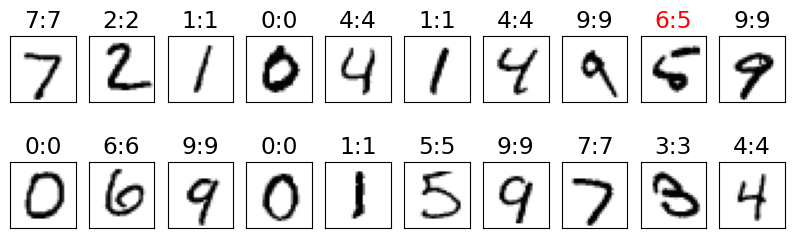

In [11]:
inputs, labels = list(test_loader)[0]
inputs = inputs.to(device)
outputs = model(inputs)
predictions = torch.max(outputs, 1)[1]

plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)
    input = inputs[i]
    label = labels[i]
    prediction = predictions[i]

    image = decode_to_image(input)
    plt.imshow(image, cmap='gray_r')

    if prediction == label:
        c = 'k'
    else:
        c = 'r'

    ax.set_title(f'{prediction}:{label}', c=c)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Convolution Network

Files already downloaded and verified
Files already downloaded and verified


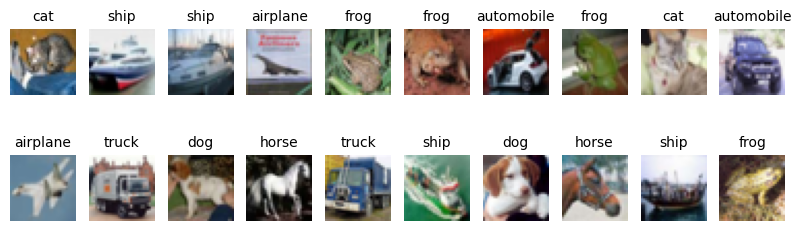

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5,  0.5),
])

def decode_to_image(x):
    x = x * 0.5 + 0.5
    return transforms.ToPILImage()(x)

train_dataset = datasets.CIFAR10(
    root = data_root, train = True,
    download = True, transform = transform)

test_dataset = datasets.CIFAR10(
    root = data_root, train = False,
    download = True, transform = transform)

batch_size = 100
classes = train_dataset.classes
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# Visualize images.
images, labels = list(test_loader)[0]

plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)
    label_name = classes[labels[i]]

    image = decode_to_image(images[i])
    plt.imshow(image)
    ax.set_title(label_name, fontsize=10)
    ax.set_axis_off()
plt.show()

In [13]:
class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2,2))
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(6272, n_hidden)
    self.l2 = nn.Linear(n_hidden, n_output)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)

    self.classifier = nn.Sequential(
       self.l1,
       self.relu,
       self.l2)

  def forward(self, x):
    x = self.features(x)
    x = self.flatten(x)
    x = self.classifier(x)
    return x

In [14]:
n_output = len(classes)
n_hidden = 128
model = CNN(n_output, n_hidden).to(device)
display(summary(model))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

train_and_test(50, model, criterion, optimizer, train_loader, test_loader, device)

Layer (type:depth-idx)                   Param #
CNN                                      --
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            9,248
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Flatten: 1-5                           --
├─Linear: 1-6                            802,944
├─Linear: 1-7                            1,290
├─Sequential: 1-8                        10,144
│    └─Conv2d: 2-1                       (recursive)
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       (recursive)
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-9                        804,234
│    └─Linear: 2-6                       (recursive)
│    └─ReLU: 2-7                         --
│    └─Linear: 2-8                       (recursive)
Total params: 1,628,756
Trainable params: 1,628,756
Non-trainable params: 0

Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/50], loss: 2.08893 acc: 0.24692 test_loss: 1.87054, test_acc: 0.34740


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.77337 acc: 0.37644 test_loss: 1.67729, test_acc: 0.41110


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/50], loss: 1.60550 acc: 0.42922 test_loss: 1.55372, test_acc: 0.44630


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/50], loss: 1.48740 acc: 0.47000 test_loss: 1.43290, test_acc: 0.48810


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/50], loss: 1.40538 acc: 0.50074 test_loss: 1.40943, test_acc: 0.49100


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/50], loss: 1.33945 acc: 0.52570 test_loss: 1.32422, test_acc: 0.52000


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/50], loss: 1.28192 acc: 0.54620 test_loss: 1.27679, test_acc: 0.54340


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/50], loss: 1.22523 acc: 0.56708 test_loss: 1.23331, test_acc: 0.55800


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/50], loss: 1.17566 acc: 0.58556 test_loss: 1.19104, test_acc: 0.57920


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/50], loss: 1.12897 acc: 0.60336 test_loss: 1.16154, test_acc: 0.59050


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/50], loss: 1.08246 acc: 0.62050 test_loss: 1.14331, test_acc: 0.59900


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/50], loss: 1.04288 acc: 0.63414 test_loss: 1.14506, test_acc: 0.59050


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.99920 acc: 0.65002 test_loss: 1.08142, test_acc: 0.61820


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.95781 acc: 0.66394 test_loss: 1.06413, test_acc: 0.62470


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.91798 acc: 0.67734 test_loss: 1.05876, test_acc: 0.62640


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.87791 acc: 0.69346 test_loss: 1.06598, test_acc: 0.62770


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.84608 acc: 0.70700 test_loss: 1.04710, test_acc: 0.63260


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.80809 acc: 0.71926 test_loss: 0.99964, test_acc: 0.65240


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.77247 acc: 0.73204 test_loss: 1.12487, test_acc: 0.60680


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.73726 acc: 0.74576 test_loss: 1.00811, test_acc: 0.64740


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.70356 acc: 0.75680 test_loss: 1.00059, test_acc: 0.65180


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.66921 acc: 0.76952 test_loss: 1.00244, test_acc: 0.65780


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.63606 acc: 0.78024 test_loss: 0.99708, test_acc: 0.66070


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.60085 acc: 0.79342 test_loss: 1.03337, test_acc: 0.65480


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.56553 acc: 0.80538 test_loss: 1.11893, test_acc: 0.63680


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.53447 acc: 0.81688 test_loss: 1.04455, test_acc: 0.66020


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.50024 acc: 0.83098 test_loss: 1.09298, test_acc: 0.65560


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.46909 acc: 0.84074 test_loss: 1.08420, test_acc: 0.66050


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.43598 acc: 0.85374 test_loss: 1.10153, test_acc: 0.65940


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.40413 acc: 0.86430 test_loss: 1.13765, test_acc: 0.65610


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.37157 acc: 0.87696 test_loss: 1.20493, test_acc: 0.65310


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.34140 acc: 0.88790 test_loss: 1.25508, test_acc: 0.64530


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.30791 acc: 0.90012 test_loss: 1.23484, test_acc: 0.65590


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.28044 acc: 0.90956 test_loss: 1.27853, test_acc: 0.64950


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.25348 acc: 0.91952 test_loss: 1.30191, test_acc: 0.66090


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.23319 acc: 0.92510 test_loss: 1.32616, test_acc: 0.66140


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.19648 acc: 0.94128 test_loss: 1.47769, test_acc: 0.64600


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.17775 acc: 0.94724 test_loss: 1.44607, test_acc: 0.65490


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.15477 acc: 0.95522 test_loss: 1.49014, test_acc: 0.65670


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.13179 acc: 0.96446 test_loss: 1.53689, test_acc: 0.64980


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.11559 acc: 0.97026 test_loss: 1.59706, test_acc: 0.64860


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.09337 acc: 0.97944 test_loss: 1.62546, test_acc: 0.66110


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.08262 acc: 0.98244 test_loss: 1.67561, test_acc: 0.65510


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.06892 acc: 0.98870 test_loss: 1.70098, test_acc: 0.65840


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.04447 acc: 0.99526 test_loss: 1.76947, test_acc: 0.66000


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.03443 acc: 0.99706 test_loss: 1.82171, test_acc: 0.65780


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.09581 acc: 0.98162 test_loss: 1.82492, test_acc: 0.65450


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.03063 acc: 0.99766 test_loss: 1.87236, test_acc: 0.66030


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.02128 acc: 0.99908 test_loss: 1.91818, test_acc: 0.66040


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.01703 acc: 0.99932 test_loss: 1.96975, test_acc: 0.65860


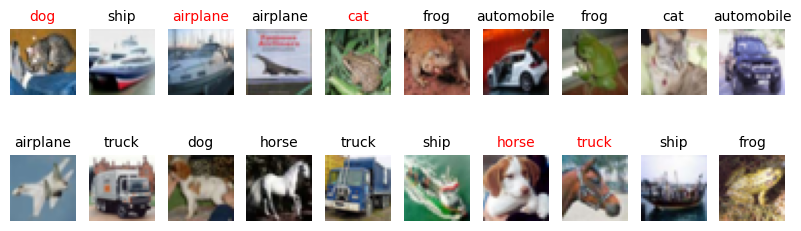

In [15]:
# Visualize images.
images, labels = list(test_loader)[0]
outputs = model(images.to(device))
predictions = torch.max(outputs, 1)[1]

plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)

    image = decode_to_image(images[i])
    label = labels[i]
    prediction = predictions[i]

    if label == prediction:
        c = 'k'
    else:
        c = 'r'

    plt.imshow(image)
    ax.set_title(classes[prediction], fontsize=10, c=c)
    ax.set_axis_off()
plt.show()

## CNN tuning
* Dropout
* Batch Normalization

In [16]:
class CNNv2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)

        self.features = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.conv2,
            self.bn2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.bn3,
            self.relu,
            self.conv4,
            self.bn4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.bn5,
            self.relu,
            self.conv6,
            self.bn6,
            self.relu,
            self.maxpool,
            self.dropout3,
        )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

Layer (type:depth-idx)                   Param #
CNNv2                                    --
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            9,248
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            36,928
├─Conv2d: 1-5                            73,856
├─Conv2d: 1-6                            147,584
├─ReLU: 1-7                              --
├─Flatten: 1-8                           --
├─MaxPool2d: 1-9                         --
├─Linear: 1-10                           262,272
├─Linear: 1-11                           1,290
├─Dropout: 1-12                          --
├─Dropout: 1-13                          --
├─Dropout: 1-14                          --
├─BatchNorm2d: 1-15                      64
├─BatchNorm2d: 1-16                      64
├─BatchNorm2d: 1-17                      128
├─BatchNorm2d: 1-18                      128
├─BatchNorm2d: 1-19                      256
├─BatchNorm2d: 1-20                    

Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/50], loss: 1.78999 acc: 0.32390 test_loss: 1.46534, test_acc: 0.46610


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.44057 acc: 0.46740 test_loss: 1.32255, test_acc: 0.51910


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/50], loss: 1.28334 acc: 0.52990 test_loss: 1.30625, test_acc: 0.53270


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/50], loss: 1.17406 acc: 0.57256 test_loss: 1.16269, test_acc: 0.58180


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/50], loss: 1.09179 acc: 0.60590 test_loss: 0.99579, test_acc: 0.64150


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/50], loss: 1.03168 acc: 0.62796 test_loss: 0.96461, test_acc: 0.65000


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.97659 acc: 0.65010 test_loss: 0.87439, test_acc: 0.69020


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.93404 acc: 0.66798 test_loss: 0.83031, test_acc: 0.70280


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.89053 acc: 0.68126 test_loss: 0.96476, test_acc: 0.65840


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.85950 acc: 0.69798 test_loss: 0.77325, test_acc: 0.72550


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.83007 acc: 0.70536 test_loss: 0.77588, test_acc: 0.72180


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.80252 acc: 0.71482 test_loss: 0.71012, test_acc: 0.75380


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.78050 acc: 0.72800 test_loss: 0.69358, test_acc: 0.75230


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.75953 acc: 0.73276 test_loss: 0.66637, test_acc: 0.76640


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.74234 acc: 0.73824 test_loss: 0.69869, test_acc: 0.75220


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.72499 acc: 0.74686 test_loss: 0.73396, test_acc: 0.74140


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.70738 acc: 0.74974 test_loss: 0.65294, test_acc: 0.76890


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.69029 acc: 0.75654 test_loss: 0.62857, test_acc: 0.77620


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.67692 acc: 0.76326 test_loss: 0.66995, test_acc: 0.76080


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.66356 acc: 0.76728 test_loss: 0.60868, test_acc: 0.78570


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.64745 acc: 0.77464 test_loss: 0.61681, test_acc: 0.78440


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.63934 acc: 0.77666 test_loss: 0.61900, test_acc: 0.78400


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.62988 acc: 0.77980 test_loss: 0.64484, test_acc: 0.77310


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.61587 acc: 0.78346 test_loss: 0.58248, test_acc: 0.79970


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.60393 acc: 0.78956 test_loss: 0.58253, test_acc: 0.79820


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.59572 acc: 0.79094 test_loss: 0.62010, test_acc: 0.78570


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.58467 acc: 0.79706 test_loss: 0.59247, test_acc: 0.79300


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.57785 acc: 0.79960 test_loss: 0.55151, test_acc: 0.80740


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.57001 acc: 0.80046 test_loss: 0.51673, test_acc: 0.82070


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.56169 acc: 0.80564 test_loss: 0.52627, test_acc: 0.81760


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.55182 acc: 0.80586 test_loss: 0.54540, test_acc: 0.81120


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.54061 acc: 0.81066 test_loss: 0.52648, test_acc: 0.81850


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.53867 acc: 0.81200 test_loss: 0.55424, test_acc: 0.80840


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.53154 acc: 0.81466 test_loss: 0.53077, test_acc: 0.81630


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.51944 acc: 0.81886 test_loss: 0.49061, test_acc: 0.83080


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.51657 acc: 0.82038 test_loss: 0.50067, test_acc: 0.82560


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.50178 acc: 0.82538 test_loss: 0.50846, test_acc: 0.82240


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.49995 acc: 0.82490 test_loss: 0.48355, test_acc: 0.83300


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.49682 acc: 0.82718 test_loss: 0.53969, test_acc: 0.81470


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.48745 acc: 0.83006 test_loss: 0.50701, test_acc: 0.82590


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.48319 acc: 0.83232 test_loss: 0.47946, test_acc: 0.83150


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.47500 acc: 0.83568 test_loss: 0.47582, test_acc: 0.83360


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.46782 acc: 0.83712 test_loss: 0.51527, test_acc: 0.82600


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.46291 acc: 0.83814 test_loss: 0.50064, test_acc: 0.83010


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.45840 acc: 0.84048 test_loss: 0.46868, test_acc: 0.83590


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.45334 acc: 0.84062 test_loss: 0.51136, test_acc: 0.82300


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.44559 acc: 0.84384 test_loss: 0.48083, test_acc: 0.83800


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.44112 acc: 0.84662 test_loss: 0.50598, test_acc: 0.83050


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43369 acc: 0.84826 test_loss: 0.47149, test_acc: 0.84020


Train:   0%|          | 0/500 [00:00<?, ?it/s]

Test:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.43296 acc: 0.84944 test_loss: 0.47254, test_acc: 0.83830


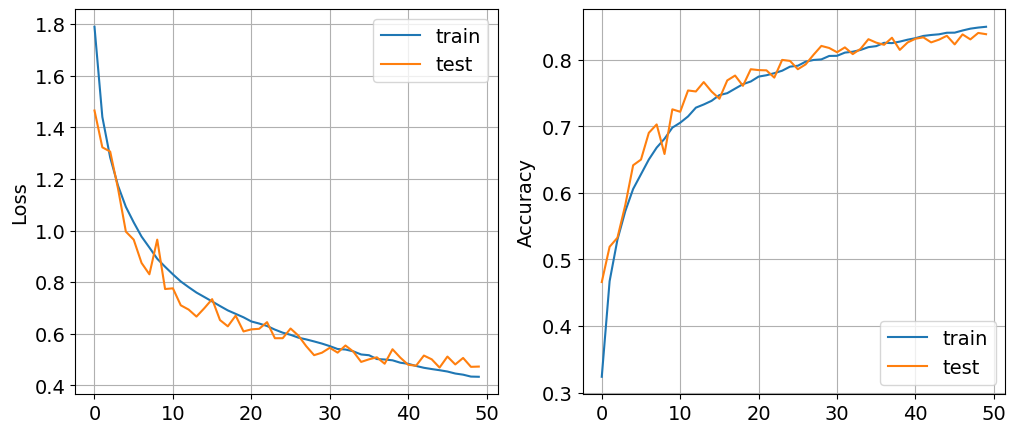

In [17]:
n_output = len(classes)
model = CNNv2(n_output).to(device)
display(summary(model))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

train_and_test(50, model, criterion, optimizer, train_loader, test_loader, device)

In [ ]:
from google.colab import runtime
runtime.unassign()